# TAREA NO. 2 - Estadística Multivariada. Análisis discriminante

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv('discriminante.csv')
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ciudad         2558 non-null   object 
 1   Altitud        2558 non-null   int64  
 2   Año            2558 non-null   int64  
 3   Mes            2558 non-null   int64  
 4   Día            2558 non-null   int64  
 5   T.Max          2556 non-null   float64
 6   T.Min          2556 non-null   float64
 7   T.media        2556 non-null   float64
 8   Dir.Viento     2558 non-null   int64  
 9   Vel.Viento     2555 non-null   float64
 10  Precipitación  2558 non-null   float64
 11  Sol            2557 non-null   float64
 12  Presión.máx    2558 non-null   float64
 13  Presión.min    2558 non-null   float64
dtypes: float64(8), int64(5), object(1)
memory usage: 279.9+ KB


(   Ciudad  Altitud   Año  Mes  Día  T.Max  T.Min  T.media  Dir.Viento  \
 0  Huelva       19  1990    1    1   15.4    9.4     12.4         300   
 1  Huelva       19  1990    1    2   14.6    6.0     10.3         270   
 2  Huelva       19  1990    1    3   13.2    8.2     10.7         270   
 3  Huelva       19  1990    1    4   15.2    6.2     10.7          10   
 4  Huelva       19  1990    1    5   15.2    9.2     12.2          70   
 
    Vel.Viento  Precipitación  Sol  Presión.máx  Presión.min  
 0         1.9            9.5  1.8       1020.0       1016.3  
 1         2.8           20.8  2.0       1020.9       1011.4  
 2         3.1            2.0  4.0       1017.4       1010.0  
 3         2.2            0.0  5.4       1024.6       1017.4  
 4         1.7            0.0  3.1       1027.3       1024.6  ,
 None)

## 1. Análisis Discriminante

### 1.1. Determinar la Multinormalidad de los datos

Para realizar un análisis discriminante, es importante verificar si los datos son aproximadamente multinormales, ya que este tipo de análisis asume que las variables tienen una distribución normal multivariada. Vamos a realizar una prueba de normalidad multivariada como la prueba de Mardia.



In [16]:
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

# Seleccionar solamente las columnas numéricas
numeric_columns = df.select_dtypes(include='float64').columns
numeric_data = df[numeric_columns]
numeric_data.head()

,T.Max,T.Min,T.media,Vel.Viento,Precipitación,Sol,Presión.máx,Presión.min
0,15.4,9.4,12.4,1.9,9.5,1.8,1020.0,1016.3
1,14.6,6.0,10.3,2.8,20.8,2.0,1020.9,1011.4
2,13.2,8.2,10.7,3.1,2.0,4.0,1017.4,1010.0
3,15.2,6.2,10.7,2.2,0.0,5.4,1024.6,1017.4
4,15.2,9.2,12.2,1.7,0.0,3.1,1027.3,1024.6


In [17]:
# Calcular la cantidad de valores nulos en cada columna
numeric_data.isnull().sum()

T.Max            2
T.Min            2
T.media          2
Vel.Viento       3
Precipitación    0
Sol              1
Presión.máx      0
Presión.min      0
dtype: int64

In [18]:
# Imputar los valores nulos con la media de la columna
numeric_data.fillna(numeric_data.mean(axis=0), inplace=True)

C:\Users\kevin\AppData\Local\Temp\ipykernel_20744\1592801117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data.fillna(numeric_data.mean(axis=0), inplace=True)


In [19]:
scaler = StandardScaler().fit(numeric_data)
numeric_data_scaled = scaler.transform(numeric_data)

In [20]:
numeric_data_scaled.mean(axis=0), numeric_data_scaled.std(axis=0)

(array([ 8.88872852e-17, -2.22218213e-16,  3.99992783e-16,  6.66654639e-17,
         5.55545532e-17, -3.55549141e-16,  2.93328041e-15, -1.18664526e-14]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

In [21]:
# Test de Shapiro-Wilk para cada columna
shapiro_results = {col: shapiro(numeric_data_scaled[:, i]) for i, col in enumerate(numeric_columns)}
shapiro_results

{'T.Max': ShapiroResult(statistic=0.9824943935444677, pvalue=3.207238308508911e-17),
 'T.Min': ShapiroResult(statistic=0.9887362211933758, pvalue=2.4911261069861235e-13),
 'T.media': ShapiroResult(statistic=0.9784670204225179, pvalue=3.0902979496840887e-19),
 'Vel.Viento': ShapiroResult(statistic=0.9584002092905829, pvalue=1.8708806622781413e-26),
 'Precipitación': ShapiroResult(statistic=0.3429155447741349, pvalue=4.187435678169307e-70),
 'Sol': ShapiroResult(statistic=0.93887896007276, pvalue=3.0599809748105805e-31),
 'Presión.máx': ShapiroResult(statistic=0.910225161435505, pvalue=1.9204196086063463e-36),
 'Presión.min': ShapiroResult(statistic=0.9187028243850723, pvalue=4.633133492107244e-35)}

Los resultados de la prueba de Shapiro-Wilk para la normalidad univariante de las variables numéricas indican que el conjunto de datos no sigue una distribución multinormal (requisito de normalidad multivariante), lo cual afecta la posibilidad de aplicar un análisis discriminante lineal (LDA), que asume normalidad en las clases. Sin embargo, aún podemos intentar aplicar Análisis Discriminante Cuadrático (QDA), que es más flexible y no requiere la estricta normalidad.

### 1.2. Análisis Discriminante Cuadrático (QDA)

In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve

X = numeric_data
y = df['Ciudad']

In [23]:
print('Las dimensiones de X son:', X.shape)
print('Las dimensiones de y son:', y.shape)

Las dimensiones de X son: (2558, 8)
Las dimensiones de y son: (2558,)


#### 1.2.1. Validación cruzada del modelo

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=33, shuffle=True, random_state=42)
accs = []
stds = []
conf_matrixs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrixs.append(conf_matrix)


Al usar KFold con el parémtro de n_splits=33, es que se van a hacer 33 particiones distintas en el dataset para train y test. De esta forma, el dataset original contiene 2558 observaciones, por lo que las particiones e teat van a quedar de aproximadamente 77 observaciones en cada una de las iteraciones. Hacerlo de esta forma permite hacer la validación cruzada.

In [25]:
# Calcular la media de las accuracy
mean_acc = np.mean(accs)

# Calcular la desviación estándar de las accuracy
std_acc = np.std(accs)

print(f'Accuracy: {mean_acc * 100.:.2f}% +/- {std_acc * 100.:.2f}%')

Accuracy: 82.61% +/- 3.65%


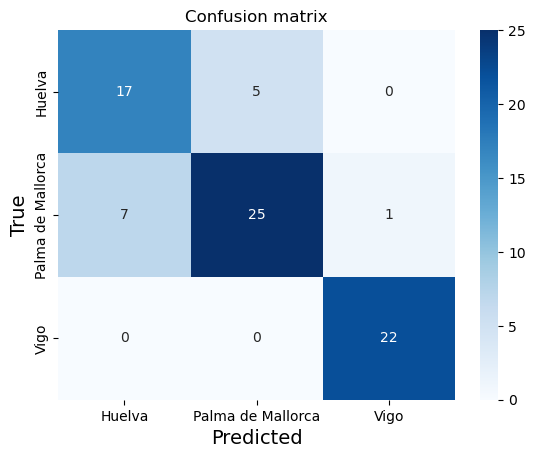

In [26]:
mean_conf_matrix = np.round(np.mean(conf_matrixs, axis=0))

# Mostrar la matriz de confusión promedio
etiquetas = np.unique(y)
sns.heatmap(mean_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion matrix')
plt.xticks(ticks=np.arange(len(etiquetas)) + 0.5, labels=etiquetas)
plt.yticks(ticks=np.arange(len(etiquetas)) + 0.5, labels=etiquetas)
plt.show()